### Decision Trees Practice Lab

This programming Assignment will run you through the steps of Decision Trees, Bagging and Random Forests. We begin this assignment by discussion the `curse of dimensionality` and its aspects. 

#### The Curse of Dimensionality

A useful way of understand the curse of dimensionality is by considering how large we have to make a neighborhood/window to include a given percentage of the data. For example, suppose we have one continuous predictor with equally spaced points in the [0,1] interval and we want to create windows that include 1/10-th of the data. Then it's easy to see that our windows have to be of size 0.1:

In [1]:
library(dplyr)
library(ggplot2)
theme_set(theme_bw(base_size = 16))
library(readr)
library(rafalib)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ tidyr   1.3.0     ✔ forcats 0.5.0
✔ purrr   1.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



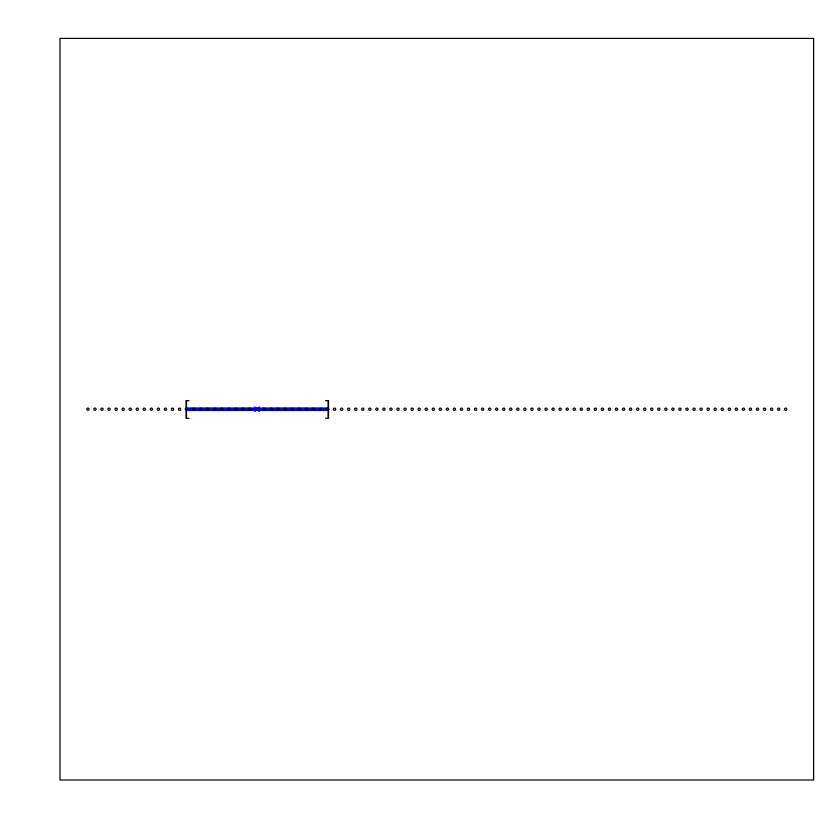

In [2]:
rafalib::mypar()
x <- seq(0, 1, len=100)
y <- rep(1, 100)
plot(x, y, xlab = "", ylab = "", cex = 0.25, yaxt = "n", xaxt = "n", type = "n")
lines(x[c(15,35)], y[c(15,35)], col = "blue", lwd = 3)
points(x,y, cex = 0.25)
points(x[25],y[25], col = "blue", cex = 0.5, pch = 4)
text(x[c(15,35)], y[c(15,35)], c("[","]"))

Now, for two predictors, if we decide to keep the neighborhood just as small, 10% for each dimension, we include only 1 point:


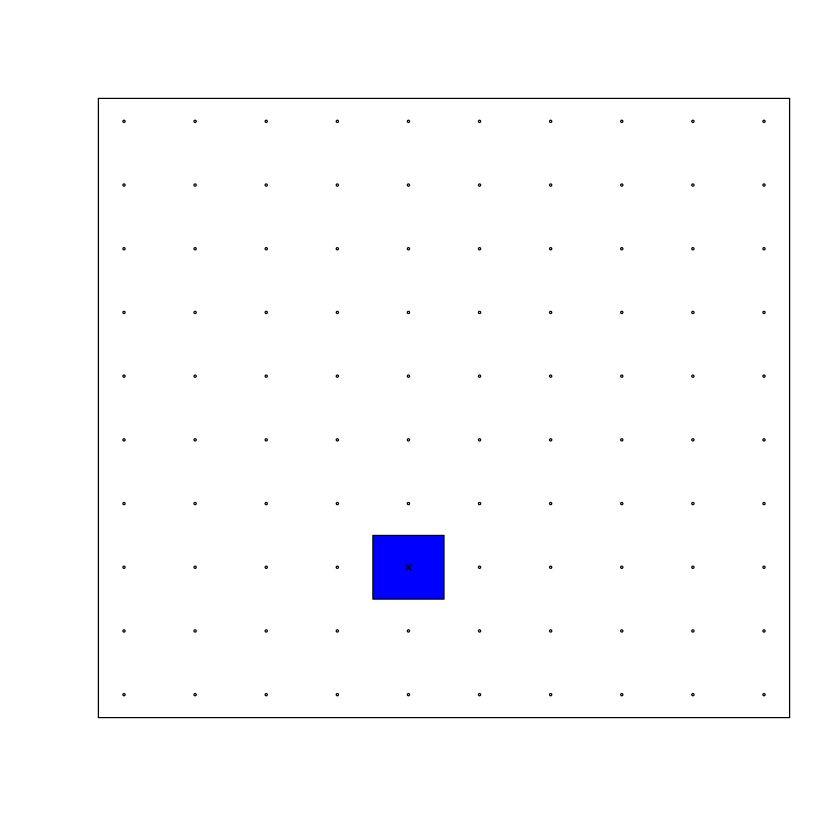

In [3]:
tmp <- expand.grid(1:10, 1:10)
x <- tmp[,1]
y <- tmp[,2]
plot(x, y, xlab = "",ylab = "", cex = 0.25, yaxt = "n", xaxt = "n",type = "n")
polygon(c(x[25]-0.5, x[25]-0.5, x[25]+0.5, x[25]+0.5),
        c(y[25]-0.5, y[25]+0.5, y[25]+0.5, y[25]-0.5), col = "blue")
points(x,y, cex = 0.25)
points(x[25], y[25], cex = 0.5, pch=4)

or, if we want to include 10% of the data we need to increase the window size to $\sqrt{10}$:


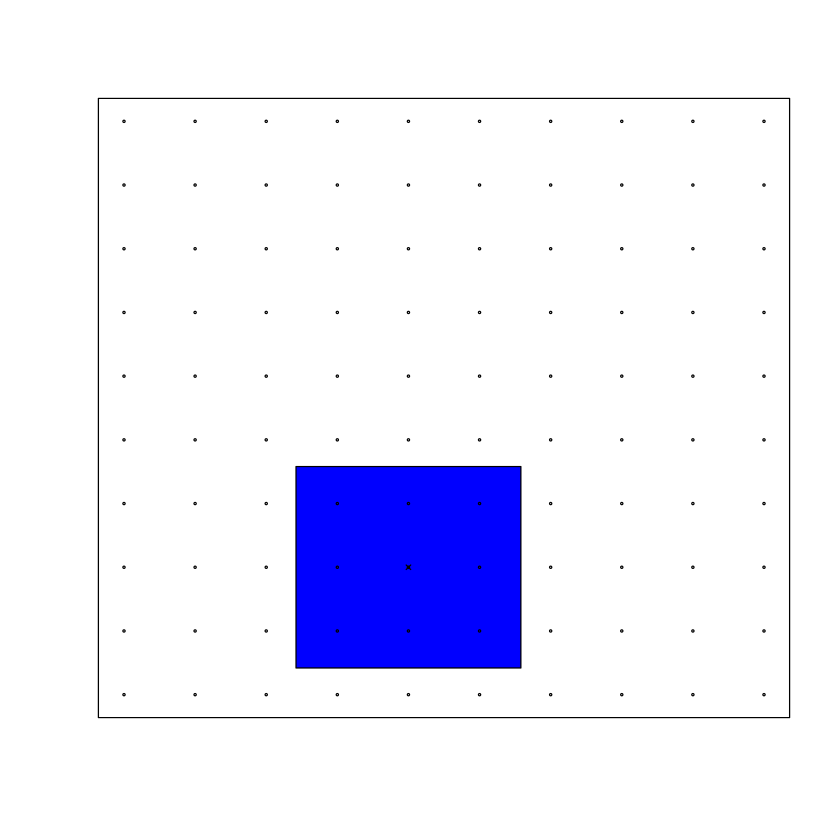

In [4]:
plot(x, y, xlab = "",ylab = "", cex = 0.25, yaxt = "n", xaxt = "n", type = "n")
polygon(c(x[25]-sqrt(10)/2, x[25]-sqrt(10)/2, x[25]+sqrt(10)/2, x[25]+sqrt(10)/2),
        c(y[25]-sqrt(10)/2, y[25]+sqrt(10)/2, y[25]+sqrt(10)/2, y[25]-sqrt(10)/2),
        col = "blue")
points(x, y, cex = 0.25)
points(x[25], y[25], cex = 0.5, pch = 4)

To include 10% of the data in a case with $p$ features we need an interval for each predictor that covers $0.10^{1/p}$ of the total. This proportion gets close to 1 (including all the data and no longer smoothing) quickly:

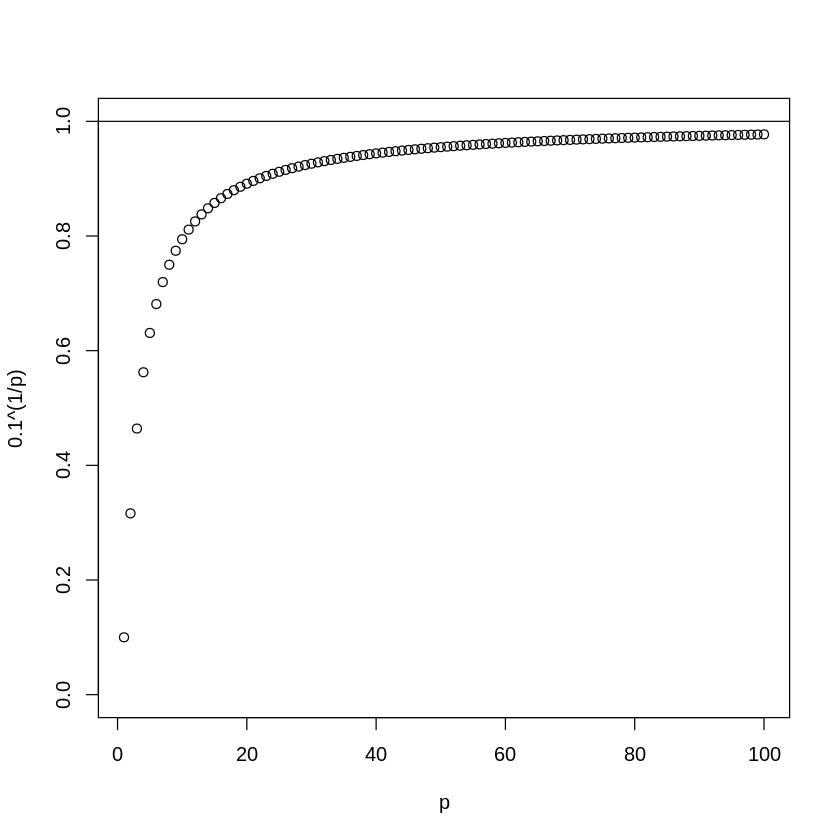

In [5]:
p <- 1:100
plot(p, .1^(1/p), ylim=c(0,1))
abline(h = 1)

Here we look at a set of elegant and versatile methods that adapt to higher dimensions and also allow these regions to take more complex shapes, but still produce models that are interpretable. These are very popular, well-known and studied methods. We will concentrate on Regression and Decision Trees and their extension to Random Forests.

#### Regression Trees

Consider the olives dataset below. We show two measured predictors, `linoleic` (percent linoleic acid of sample) and `eicosenoic` (percent eicosenoic acid of sample). Suppose we wanted to predict the olive's region using these two predictors.

Warning message:
“`tbl_df()` was deprecated in dplyr 1.0.0.
ℹ Please use `tibble::as_tibble()` instead.”


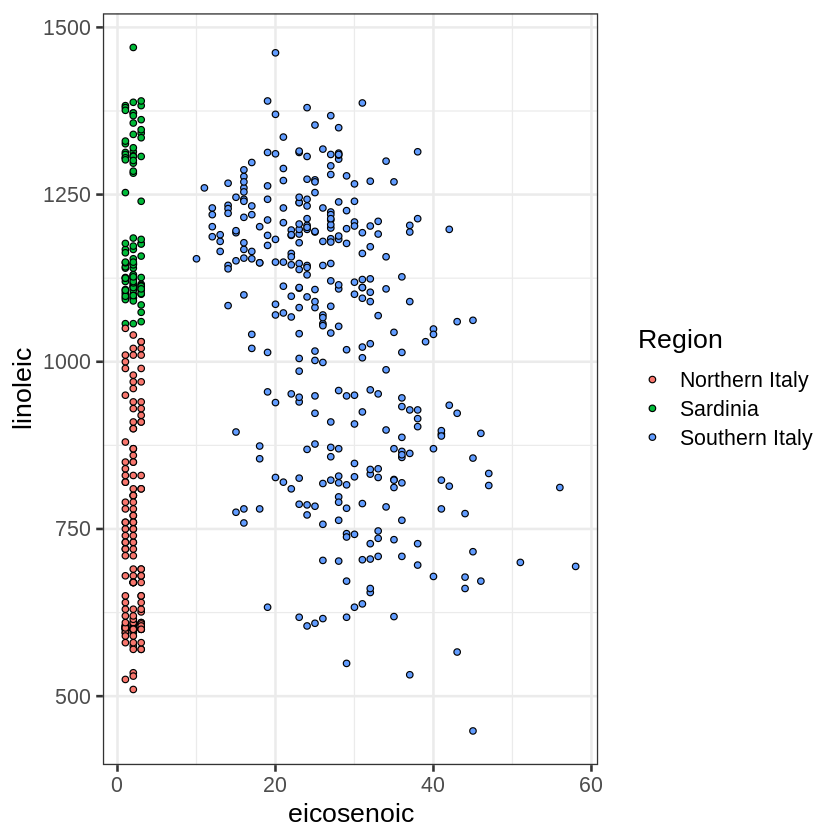

In [6]:
olives <- read.csv("https://raw.githubusercontent.com/datasciencelabs/data/master/olive.csv", as.is = TRUE) %>% tbl_df
names(olives)[1] <- "province"
region_names <- c("Southern Italy", "Sardinia", "Northern Italy")
olives <- olives %>% mutate(Region = factor(region_names[Region]))

p <- olives %>% ggplot(aes(eicosenoic, linoleic, fill = Region)) +
     geom_point(pch = 21)
p

Note that we can describe a classification algorithm that would work pretty much perfectly:


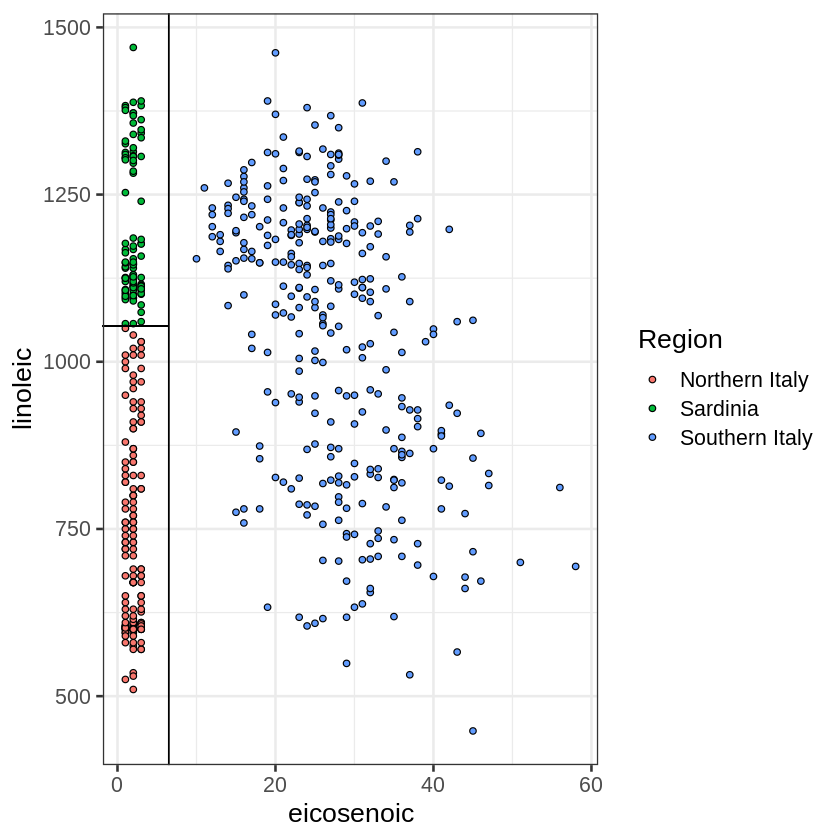

In [7]:
p <- p + geom_vline(xintercept = 6.5) + 
         geom_segment(x = -2, y = 1053.5, xend = 6.5, yend = 1053.5)
p

The prediction algorithm inferred from the figure above is what we call a decision tree. If eicosnoic is larger than 6.5, predict Southern Italy. If not, then if linoleic is larger than 1,054, predict Sardinia and Northern Italy otherwise. We can draw this decision tree like this:

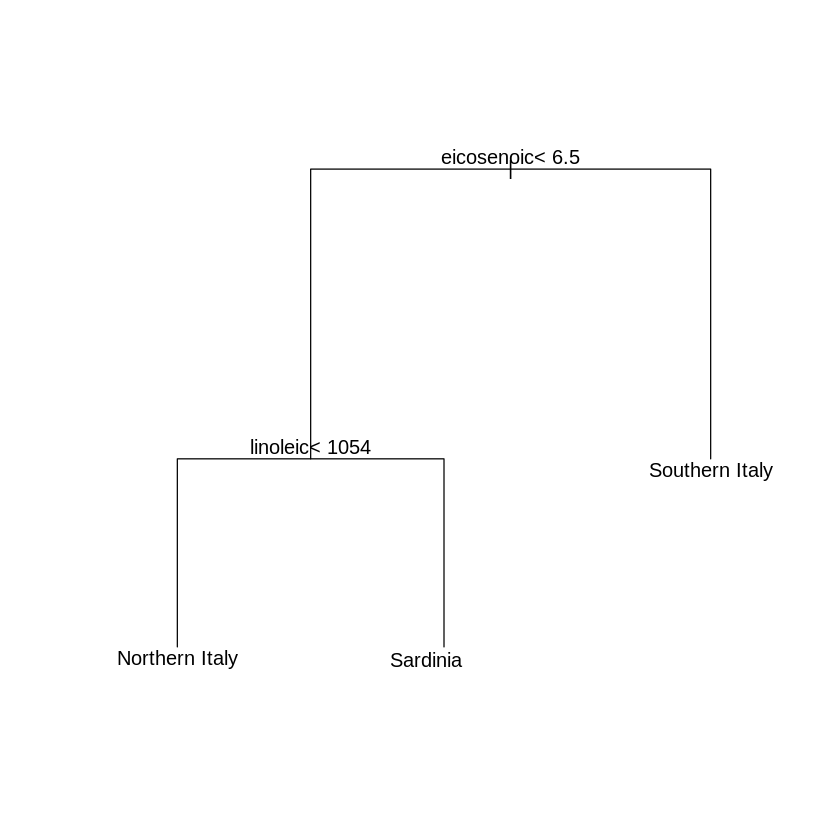

In [8]:
library(rpart)
olives <- olives %>% dplyr::select(., Region, linoleic, eicosenoic)
fit <- rpart(as.factor(Region)~., data = olives)
plot(fit, margin = 0.1)
text(fit, cex = 1)

Decision trees like this are often used in practice. For example, to decide if a person is at risk of having a heart attack, doctors use the following:

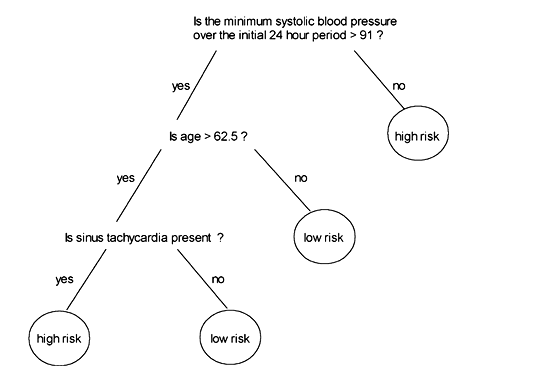

The general idea of the methods we are describing is to define an algorithm that uses data to create these tress. Regression and decision trees operate by predicting an outcome variable $Y$ by **partitioning** feature (predictor) space.

#### Regression Trees

Let's start with the case of a **continuous** outcome. The general idea here is to build a decision tree and at the end of each _node_ we will have a different prediction $\hat{Y}$ for the outcome $Y$.

The **regression** tree model then:

1. Partitions space into $J$ non-overlapping regions, $R_1, R_2, \ldots, R_J$.
2. For every observation that falls within region $R_j$, predict the response as the mean of responses for training observations in $R_j$.

The important observation is that **Regression Trees create partitions recursively**.

For example, consider finding a good predictor $j$ to partition space along its axis. A recursive algorithm would look like this:

Find predictor $j$ and value $s$ that minimize RSS:

$$
\sum_{i:\, x_i \in R_1(j,s))} (y_i - \hat{y}_{R_1})^2 +
\sum_{i:\, x_i \in R_2(j,s))} (y_i - \hat{y}_{R_2})^2
$$

Where $R_1$ and $R_2$ are regions resulting from splitting observations on predictor $j$ and value $s$:

$$
R_1(j,s) = \{X|X_j < s\} \text{ and } R_2(j,s) \{X|X_j \geq s\}
$$

This is then applied recursively to regions $R_1$ and $R_2$. Within each region a prediction is made using $\hat{y}_{R_j}$ which is the mean of the response $Y$ of observations in $R_j$.

Let's take a look at what this algorithm does on the `Boston Housing` data set. This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston, MA in the 1970s. It was obtained from the [StatLib archive](http://lib.stat.cmu.edu/datasets/boston). It contains information including `medv` (median value of owner-occupied homes in $1000's), `lstat` (% of individuals with lower socioeconomic status), `rm` (average number of rooms per dwelling), and `dis` (weighted distances to five Boston employment centres), among others with a total of 14 variables. 

The dataset is small in size with only 506 cases, but we'll use it for educational purposes.


In [9]:
library(tree)
library(MASS)

set.seed(1)
# Randomly sample half of the data for training
train = sample(1:nrow(Boston), nrow(Boston)/2) 
# Fit a regression tree using all of the available predictors
fit = tree(medv ~ ., Boston, subset = train)  
# Print a summary of the tree
summary(fit)
# Use tree for prediction
preds <- predict(fit, newdata = Boston[-train,])
test = Boston[-train, "medv"]


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select





Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

In [10]:
head(Boston)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [11]:
train

[1] 505 324 167 129 418 471 299 270 466 187 307 481  85 277 362 438 330 263
 [19] 329  79 213  37 105 217 366 165 290 492 382  89 428 463 289 340 419 326
 [37] 490  42 422 111 404 412  20  44 377 343  70 121  40 172  25 375 248 198
 [55] 378  39 435 298 390 280 160  14 130  45 402  22 206 230 193 371 104 501
 [73] 255 450 436 103 331  13 296 483 176 345 279 110  84 359  29 141 252 406
 [91] 221 465 108 304  33 443 149 287 102 145 488 461 339 118 346 413 107  64
[109] 224 431 316  51 416 480 138 503 500 282 143 285 170  48 204 295  24 181
[127] 214 476 225 498 442 163  43   1 420  78 433 284 116 233 293  61  86 327
[145] 423 355 496 300  49 396 242 246 305 306 247 239 219 135 467 464 395  53
[163] 444 401  65 421 484 124  77 218  98 194  19 273  31 174 237  75  16 458
[181] 265 353  92 122 152 392 207 249 446 229 140 126 445 368 328 271 344 342
[199] 333 212 127 133  41  36 297 399 391 360 117 408  50 286 254  72 437 168
[217] 313 113 234 459  73  27 405  15  62 132  35 338 473 185 153 332 485 434
[235] 231  28 389 148 325  60 275  93 202 336 241 415 281 449 364 427 478 274
[253] 414

In [12]:
test

[1] 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.0 18.9 23.1 17.5 13.6 15.2
 [16] 13.9 21.0 14.5 13.1 21.0 19.3 20.0 20.5 23.4 18.9 35.4 24.7 31.6 23.3 22.2
 [31] 23.5 19.4 22.0 17.4 24.2 23.4 21.4 20.3 28.0 23.9 24.8 22.5 22.2 28.7 22.6
 [46] 25.0 20.6 28.4 21.4 43.8 33.2 27.5 19.5 19.8 22.8 18.7 18.5 20.4 19.3 20.5
 [61] 18.8 16.2 19.2 18.4 18.1 17.4 13.3 14.4 15.6 13.8 15.6 15.4 21.5 19.4 17.0
 [76] 15.6 13.1 41.3 24.3 27.0 50.0 50.0 25.0 23.8 17.4 23.1 22.6 23.2 24.6 29.9
 [91] 37.2 36.2 37.9 32.5 29.6 32.0 29.8 34.9 37.0 30.5 29.1 50.0 33.3 34.6 34.9
[106] 32.9 42.3 50.0 22.5 24.4 20.0 21.7 23.7 25.0 23.0 21.7 27.5 50.0 37.6 31.6
[121] 31.7 29.0 24.0 31.5 23.3 22.2 23.7 17.6 26.2 24.4 29.6 20.9 44.0 50.0 36.0
[136] 30.1 33.8 43.1 31.0 22.8 30.7 50.0 43.5 25.2 32.0 33.1 46.0 23.2 28.5 37.3
[151] 23.9 24.8 22.0 26.4 28.2 22.8 20.3 16.1 22.1 21.6 23.8 17.8 19.8 23.1 21.0
[166] 23.8 23.1 20.4 22.2 20.7 19.5 18.7 17.2 23.1 24.5 26.6 22.9 24.1 30.1 20.6
[181] 17.8 21.7 25.0 20.8 21.9 21.9 50.0 50.0 50.0 50.0 13.8 15.0 13.1 10.2 10.4
[196] 11.3 12.3  8.8  7.2 10.5  7.4  9.7 13.8 12.5  8.5  6.3 12.1 11.9 17.2 27.5
[211] 15.0  7.5 13.4 11.7  8.3 11.0  9.5 14.1  8.4 12.8 10.5 14.9 12.6 13.4 15.2
[226] 16.1 17.8 14.9 14.1 12.7 20.0 17.7 19.1 19.1 20.1 19.6 29.8 13.8 16.7 14.6
[241] 23.7 21.2 19.1 15.2  8.1 20.1 21.8 24.5 19.7 21.2 22.4 23.9 11.9

Note that the output indicates only 3 of the predictors were used to construct the tree. Let's plot it and take a look:

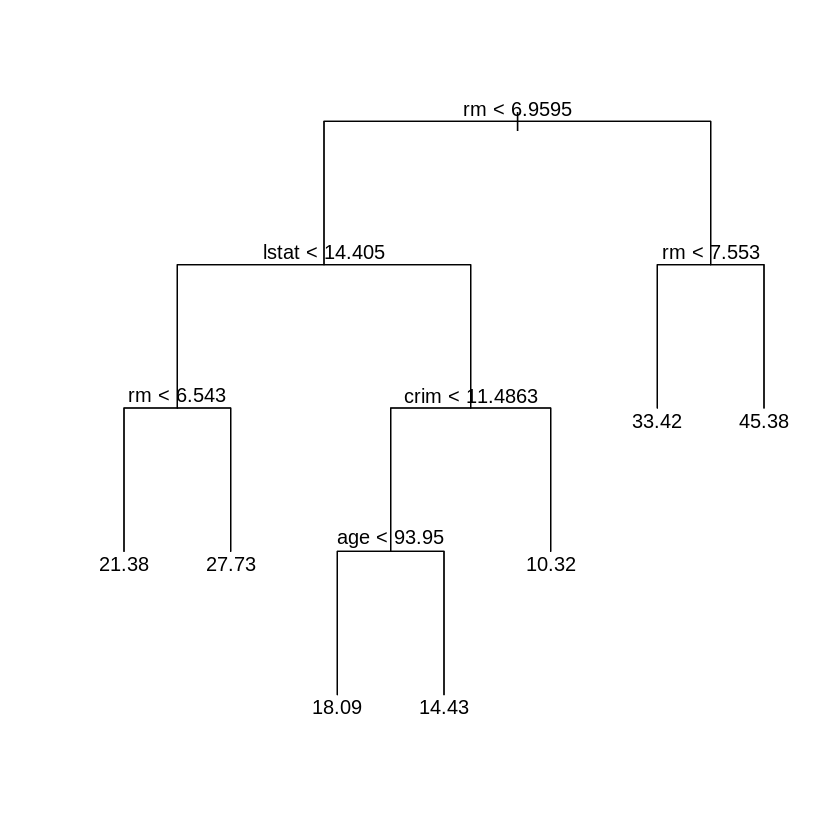

In [13]:
plot(fit, type = "uniform")
text(fit, cex = 1)

The tree suggests that lower values of `lstat` correspond to more expensive houses and predicts a median house price of $46,380 for larger homes in the suburbs in which residents have high socioeconomic status (`rm` >= 7.437 and `lstat` < 9.715). 

The idea behind the regression tree is that outcome $Y$ is estimated (or predicted) to be it's mean _within each of the data partitions_. Think of it as the conditional mean of $Y$ where conditioning is given by this region partitioning. 

We can also use the predictions made to calculate MSE (mean square error) to compare models. 

[1] 35.28688

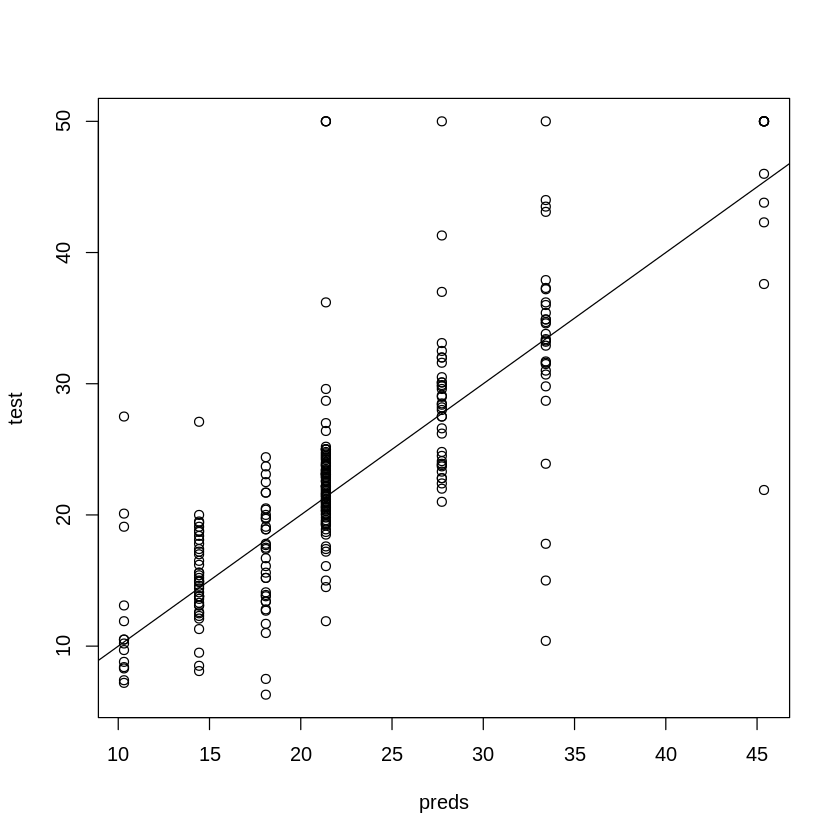

In [14]:
plot(preds, test)
abline(0,1)
mean((preds-test)^2)

The test set MSE associated with this tree is 25.05. The square root of the MSE is 5.005, indicating this model leads to test predictions that are within approximately $5,005 of the true median home value for the suburb.

#### Specifics of the regression tree algorithm

The recursive partitioning algorithm described above leads to a set of natural questions:

1. _When do we stop partitioning?_ 

We stop when adding a partition does not reduce MSE, or, when a partition has too few training observations. Even then, trees built with this stopping criterion tend to _overfit_ to the training data. To avoid this, a post-processing step called **pruning** is used to make the tree smaller.

2. Why would a smaller tree tend to generalize better?

The `cv.tree` function is used to determine a reasonable tree depth for the given dataset. For this dataset it seems that a depth of 8 works well since it reaches the minimum error or "deviance" with that number:

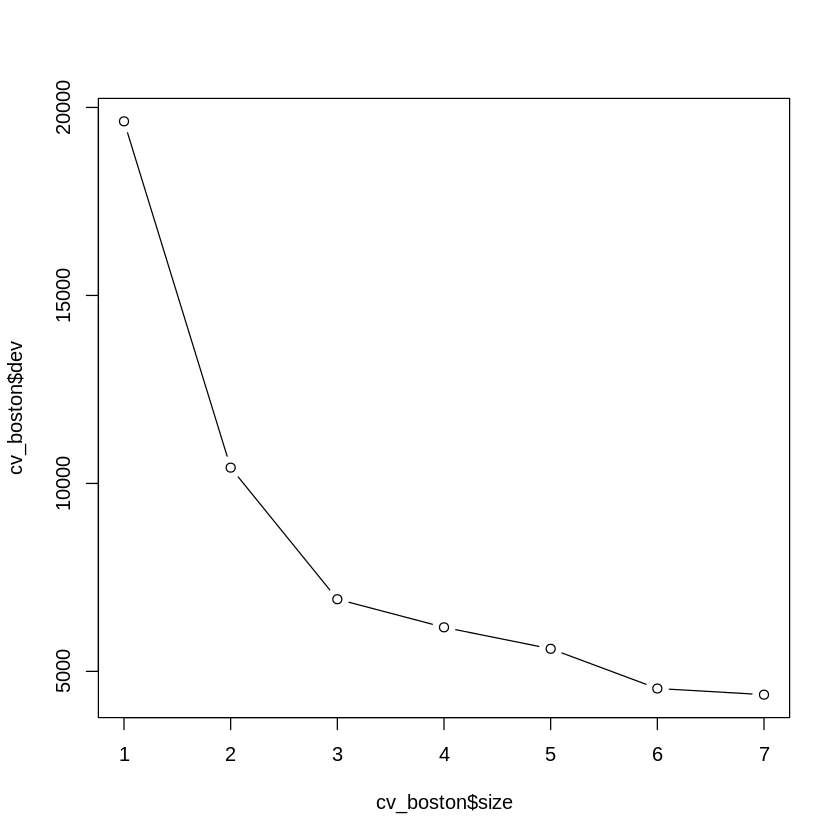

In [15]:
cv_boston = cv.tree(fit)
plot(cv_boston$size, cv_boston$dev, type = 'b')

However, if we decide to prune a tree we can do so using the `prune.tree()` function:


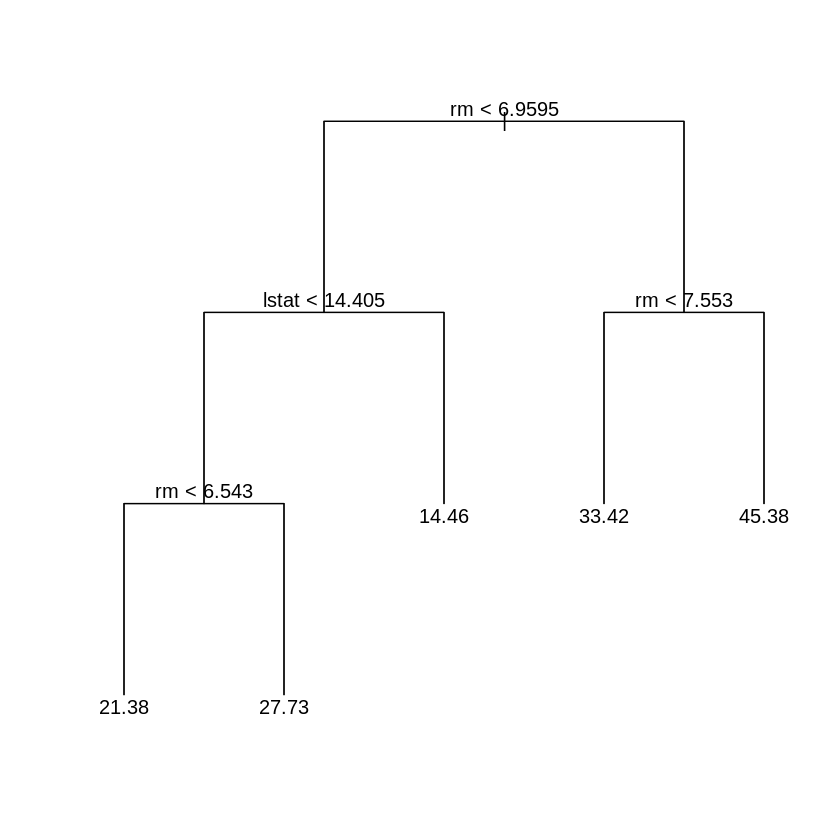

In [16]:
prune_boston = prune.tree(fit, best = 5)
plot(prune_boston, type = "uniform")
text(prune_boston)

Let's calculate the test set MSE for the pruned tree:

In [17]:
preds_prune <- predict(prune_boston, newdata = Boston[-train,])
test = Boston[-train, "medv"]
mean((preds_prune-test)^2)

[1] 35.90102

The MSE of the pruned tree is greater than the original, so we should not prune this decision tree.

#### Classification (Decision) Trees

Classification, or decision trees, are used in classification problems where the outcome is categorical. The same partitioning principle is used, but now each region predicts the **majority** class for training observations within that region. The recursive partitioning algorithm we saw previously requires a score function to choose predictors (and values) to partition with. In classification we could use a naive approach of looking for partitions that minimize training error. However, better performing approaches use more sophisticated metrics. Here are two of the most popular (denoted for leaf $m$):
 
  - **Gini Index**: $\sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$, or
  
  - **Entropy**: $-\sum_{k=1}^K \hat{p}_{mk}\log(\hat{p}_{mk})$
  
where $\hat{p}_{mk}$ is the proportion of training observations in partition $m$ labeled as class $k$. Both of these seek to partition observations into subsets that have the same labels.

Let us look at how a classification tree performs on the digits example we examined before:

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


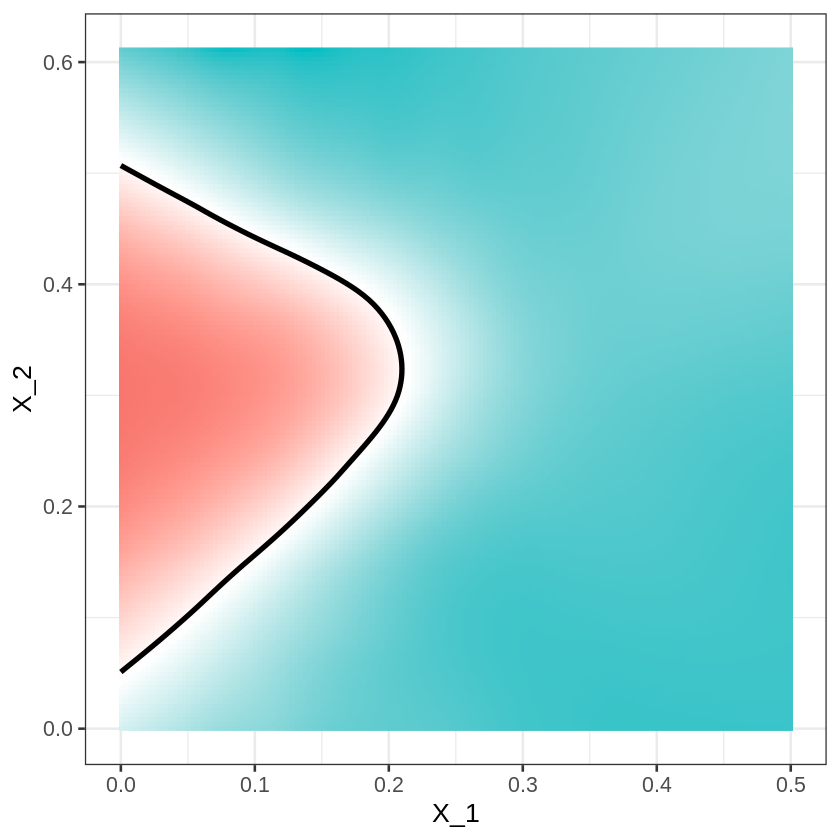

In [18]:
digits <- read.csv("hand-written-digits-train.csv")
digits <- digits %>% filter(label %in% c(2,7))
digits <- mutate(digits, label =  as.character(label)) %>% 
          mutate(label = ifelse(label=="2",0,1 ))
row_column <- expand.grid(row=1:28, col=1:28)
ind1 <- which(row_column$col <= 14 & row_column$row <=14)
ind2 <- which(row_column$col > 14 & row_column$row > 14)
ind <- c(ind1, ind2)
X <- as.matrix(digits[,-1])
X <- X>200
X1 <- rowSums(X[,ind1])/rowSums(X)
X2 <- rowSums(X[,ind2])/rowSums(X)
digits <- mutate(digits, X_1 = X1, X_2 = X2) %>% dplyr::select(., label, X_1, X_2) %>%
  mutate(label = as.factor(label))
y <- digits$label
x <- cbind(X1, X2)
library(caret)
fit <- knn3(x, y, 51)
GS <- 150
X1s <- seq(min(X1),max(X1),len=GS)
X2s <- seq(min(X2),max(X2),len=GS)
true_f <- expand.grid(X_1=X1s, X_2=X2s)
yhat <- predict(fit, newdata = true_f, type="prob")[,2]
true_f <- mutate(true_f, yhat=yhat)
f <- loess(yhat~X_1*X_2, data=true_f, 
           degree=1, span=1/5)$fitted
true_f <- true_f %>% mutate(f=f) 
rm(X,X1,X2,fit,GS,X1s,X2s,yhat,f)

true_f_plot <- true_f %>%
  ggplot(aes(X_1, X_2, fill=f))  +
  scale_fill_gradientn(colors=c("#F8766D","white","#00BFC4")) + geom_raster()  + guides(fill=FALSE) +  
  stat_contour(aes(x=X_1,y=X_2,z=f), data=true_f, breaks=c(0.5),color="black",lwd=1.5)
true_f_plot

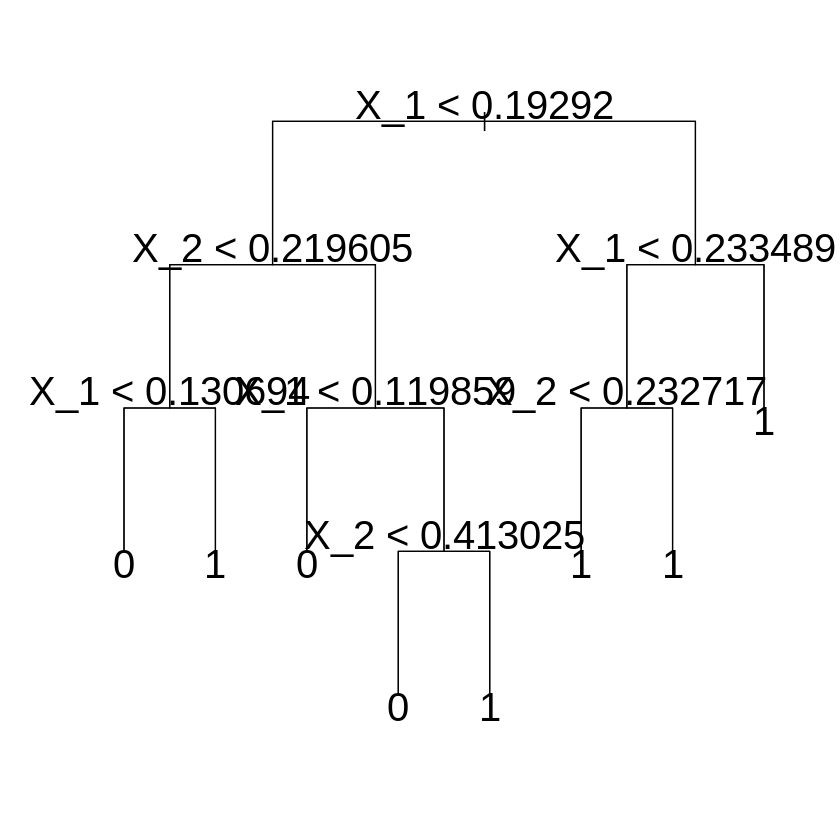

In [19]:
inTrain <- createDataPartition(y = digits$label, p = 0.5)
digits_train <- slice(digits, inTrain$Resample1)
digits_test  <- slice(digits, -inTrain$Resample1)

fit <- tree(label ~ X_1 + X_2, data = digits_train)
plot(fit, type = "uniform")
text(fit, cex = 2, digits = 2)

We can see the prediction here:


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


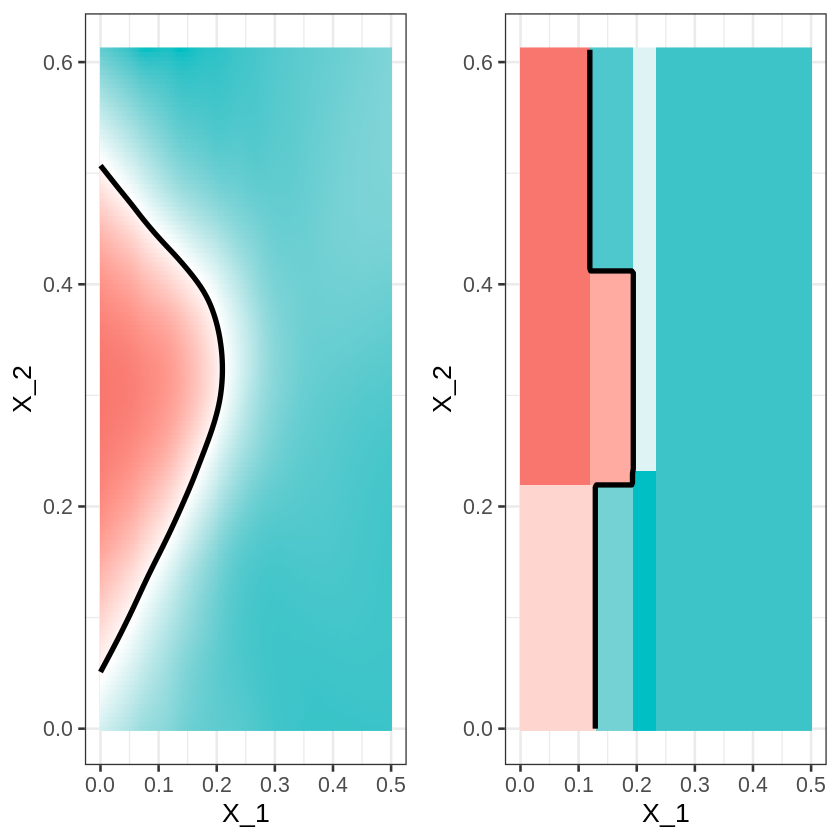

In [20]:
f_hat_cart <- predict(fit, newdata = true_f)[,2]

p <-true_f %>% mutate(f = f_hat_cart) %>%
               ggplot(aes(X_1, X_2, fill = f)) +
               scale_fill_gradientn(colors = c("#F8766D","white","#00BFC4")) + 
               geom_raster() +  
               stat_contour(aes(x = X_1, y = X_2, z = f), 
               data = mutate(true_f, f = f_hat_cart),
               breaks = c(0.5), color = "black", lwd = 1.5) +
               guides(fill = FALSE)

library(gridExtra)
grid.arrange(true_f_plot, p, nrow=1)

We can again prune the tree if we wish, but in this case the pruned tree does not differ much from the original.


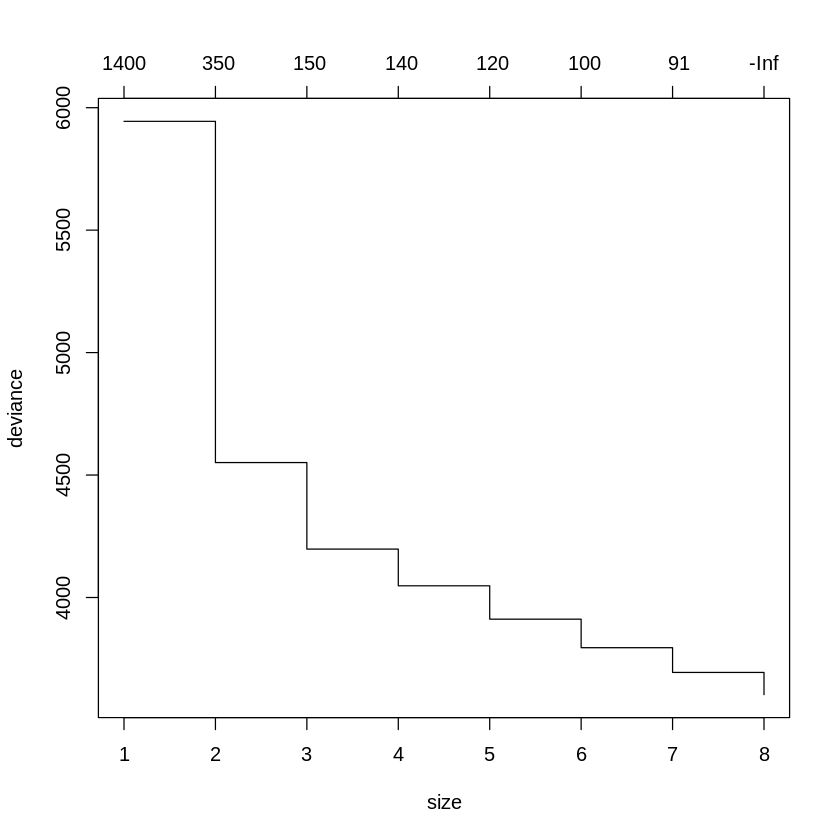

In [21]:
pruned_fit <- prune.tree(fit)
plot(pruned_fit)

Here is what a pruned tree looks like:

Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


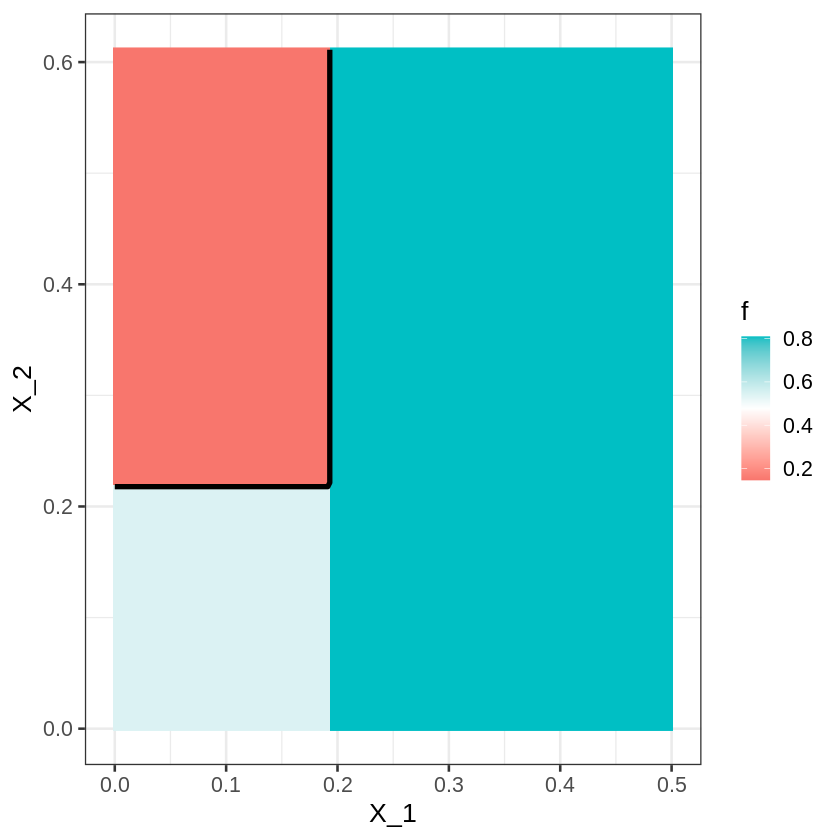

In [22]:
pruned_fit  <- prune.tree(fit, k = 160)
f_hat_cart2 <- predict(pruned_fit, newdata = true_f)[,2]
p <-true_f %>% mutate(f = f_hat_cart2) %>%
               ggplot(aes(X_1, X_2, fill = f)) +
               scale_fill_gradientn(colors = c("#F8766D","white","#00BFC4")) + 
               geom_raster() +  
               stat_contour(aes(x = X_1, y = X_2, z = f), 
               data = mutate(true_f, f = f_hat_cart2),
               breaks = c(0.5),color = "black", lwd = 1.5)
p

Classification trees have certain advantages that make them very useful. They are highly interpretable, even more so than linear models, are easy to visualize (if small enough), and they (maybe) model human decision processes and don't require that dummy predictors for categorical variables are used.

On the other hand, the greedy approach via recursive partitioning is a bit harder to train than linear regression. It may not always be the best performing method since it is not very flexible and is highly unstable to changes in training data. Below we will learn about the bootstrap to help with this.

#### Bootstrap

Suppose the income distribution of your population is as follows:

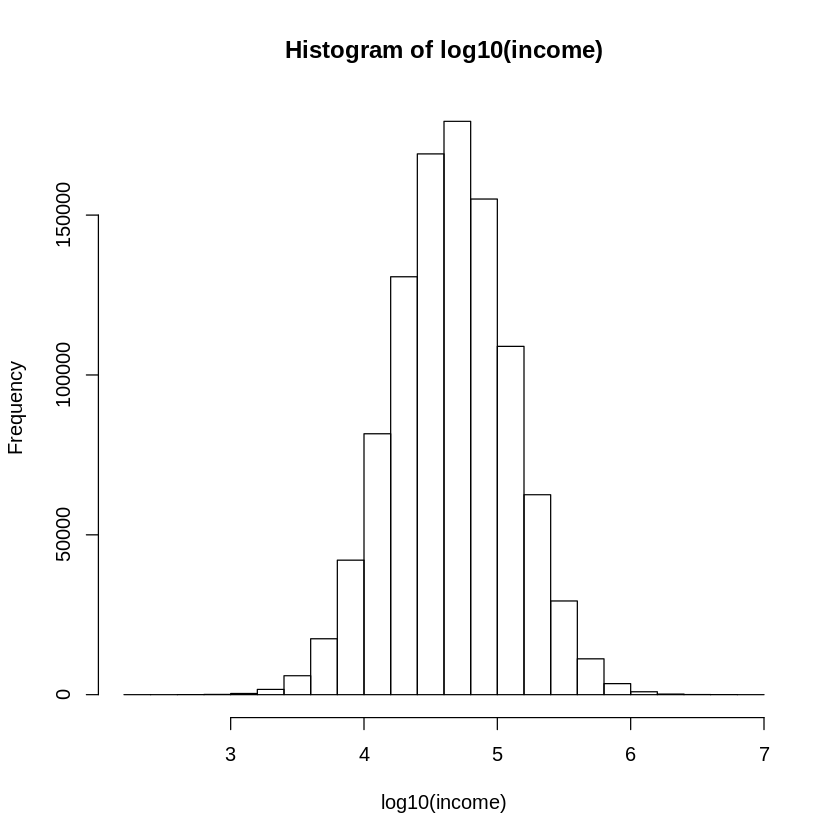

In [23]:
n <- 10^6
income <- 10^(rnorm(n, 4.656786, 0.4394738))

hist(log10(income))

The population median is:

In [24]:
m <- median(income)
m

[1] 45317.72

Suppose we don't have access to the entire population but want to estimate the median $m$. We take a sample of 250 and estimate the population median $m$ with the sample median $M$:


In [25]:
set.seed(1)
N <- 250
X <- sample(income, N)
M <- median(X)
M

[1] 41626.3

Can we construct a confidence interval? What is the distribution of $M$?

From a Monte Carlo simulation we see that the distribution of $M$ is approximately normal with the following expected value and standard error:

[1] 45471.42

[1] 3650.328

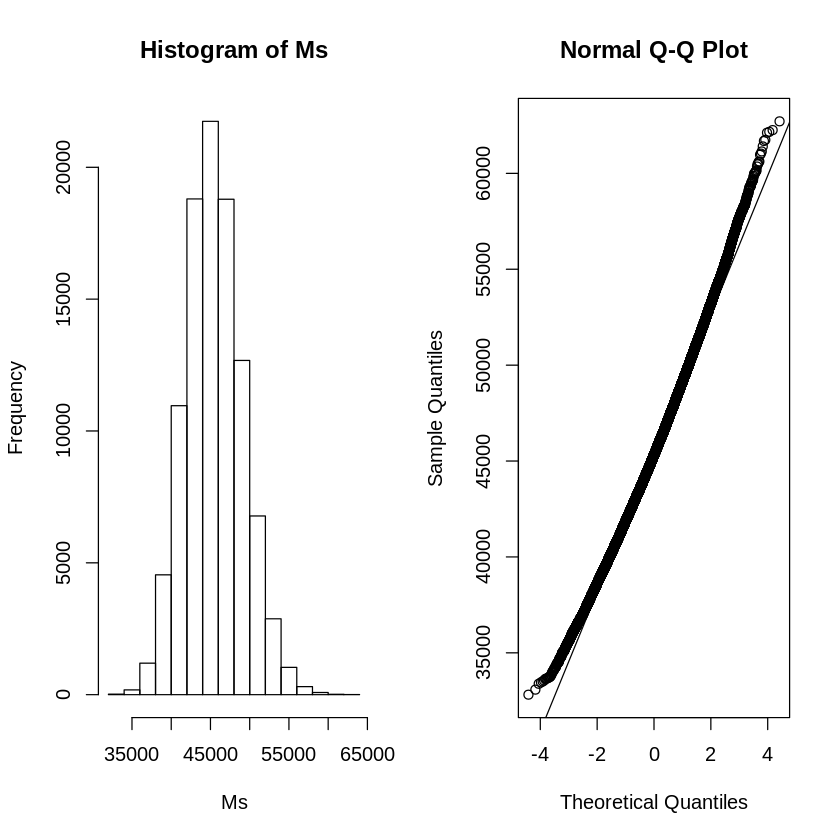

In [26]:
B <- 10^5
Ms <- replicate(B, {
  X <- sample(income, N)
  M <- median(X)
})
par(mfrow=c(1,2))
hist(Ms)
qqnorm(Ms)
qqline(Ms)
mean(Ms)
sd(Ms)

The problem here is that, as we have described before, in practice we do not have access to the distribution. In the past we have used the central limit theorem. But the CLT we studied applies to _averages_ and here we are interested in the _median_. 

The Bootstrap permits us to approximate a Monte Carlo simulation without access to the entire distribution. The general idea is relatively simple. We act as if the sample is the distribution and sample (with replacement) datasets of the same size. Then we compute the summary statistic, in this case the median, on this _bootstrap sample_. 

There is theory telling us that the distribution of the statistics obtained with bootstrap samples approximate the distribution of our actual statistic. This is how we construct bootstrap samples and an approximate distribution:

In [27]:
B <- 10^5
M_stars <- replicate(B, {
  X_star <- sample(X, N, replace = TRUE)
  M_star <- median(X_star)
})

Now we can check how close it is to the actual distribution

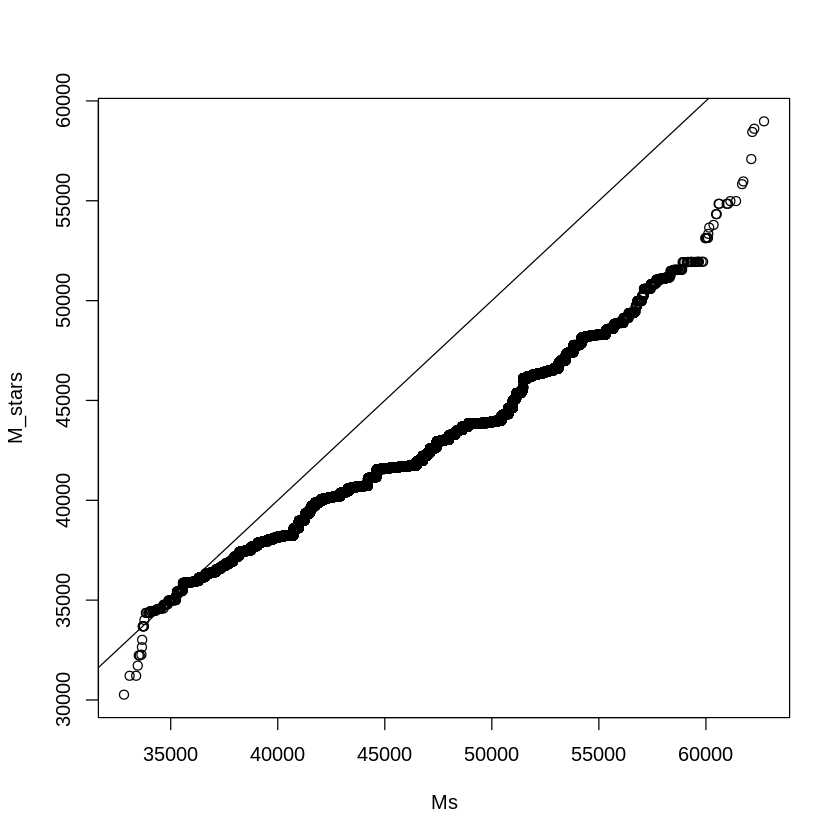

In [28]:
qqplot(Ms, M_stars)
abline(0,1)  

We see it is not perfect but it provides a decent approximation:


In [29]:
quantile(Ms, c(0.05, 0.95))
quantile(M_stars, c(0.05, 0.95))

5%      95% 
39727.90 51722.74

5%      95% 
38041.02 46207.35

This is much better than what we get if we mindlessly use the CLT:

In [30]:
median(X) + 1.96 * sd(X)/sqrt(N) * c(-1,1)

[1] 29392.54 53860.06

If we know the distribution is normal, we can use the bootstrap to estimate the mean:

In [31]:
mean(Ms) + 1.96*sd(Ms)*c(-1,1)
mean(M_stars) + 1.96*sd(M_stars)*c(-1,1)

[1] 38316.78 52626.07

[1] 37239.74 46112.89

#### Random Forests

Random Forests are a **very popular** approach that address the shortcomings of decision trees via re-sampling of the training data. Their goal is to improve prediction performance and reduce instability by _averaging_ multiple decision trees (a forest constructed with randomness). It has two features that help accomplish this.

The first trick is *Bagging* (bootstrap aggregation)
General scheme:

  1. Build many decision trees $T_1, T_2, \ldots, T_B$ from training set
  2. Given a new observation, let each $T_j$ predict $\hat{y}_j$
  3. For regression: predict average $\frac{1}{B} \sum_{j=1}^B \hat{y}_j$,
     for classification: predict with majority vote (most frequent class)
     
But how do we get many decision trees from a single training set?

For this we use the _bootstrap_. To create $T_j, \, j=1,\ldots,B$ from a training set of size $N$:

a) Create a bootstrap training set by sampling $N$ observations from training set **with replacement**
b) Build a decision tree from the bootstrap training set

Let's look at this using the Boston housing dataset. We fit a Random Forest by using the `randomForest()` function. Here, `mtry = 13` indicates all 13 predictors should be considered for each split of the tree - in other words, bagging should be done. 

In [32]:
library(randomForest)
library(MASS)
fit_bag <- randomForest(medv ~ ., data = Boston, mtry = 13)
fit_bag

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine





Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 10.54275
                    % Var explained: 87.51

How well does it perform on the test set?

[1] 2.304846

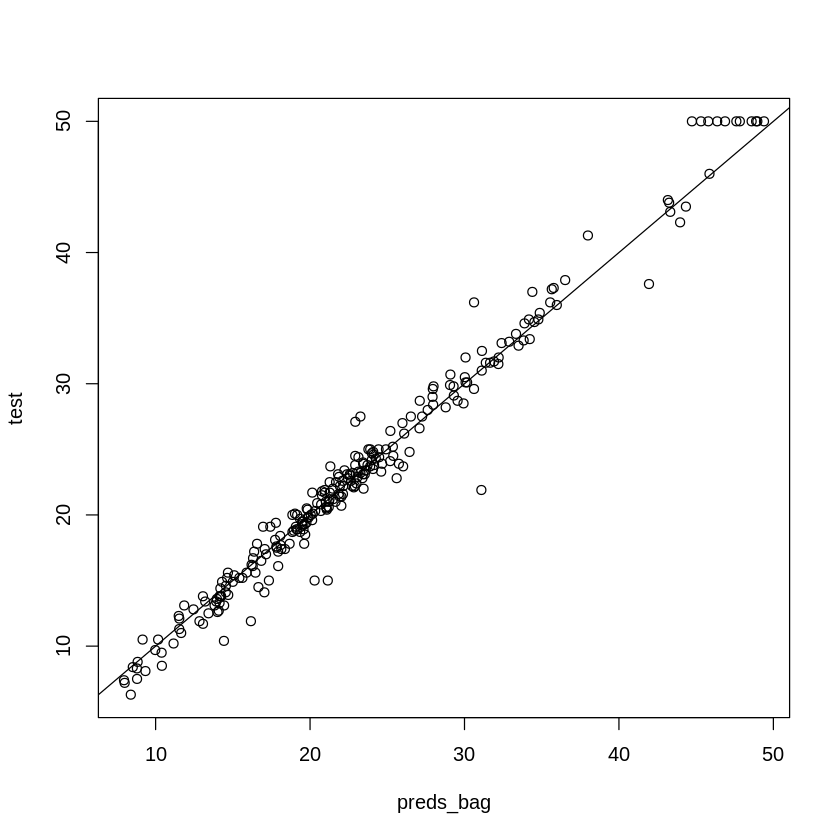

In [33]:
preds_bag = predict(fit_bag, newdata = Boston[-train,])
plot(preds_bag, test)
abline(0,1)
mean((preds_bag - test)^2)

Much, much better than the one decision tree we used above. 

We can grow a random forest in the same way, except now we use a smaller value for `mtry`. The default for regression trees is $p/3$ ($p$ is the number of predictors) and the default for classification trees is $\sqrt p$. Let's try `mtry = 6`.

In [34]:
fit_rf <- randomForest(medv ~ ., data = Boston, mtry = 6, importance = TRUE)
preds_rf = predict(fit_rf, newdata = Boston[-train,])
mean((preds_rf - test)^2)

[1] 2.265554

Looks like the MSE for this random forest is worse with fewer predictors and the one using all of the predictors performs the best.

The second Random Forests feature is to use a random selection of features to split when deciding partitions. Specifically, when building each tree $T_j$, at each recursive partition only consider a _randomly selected subset of predictors_ to check for the best split. This reduces correlation between trees in a forest, improving prediction accuracy.

Here is the random forest fit for the digits data:

Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


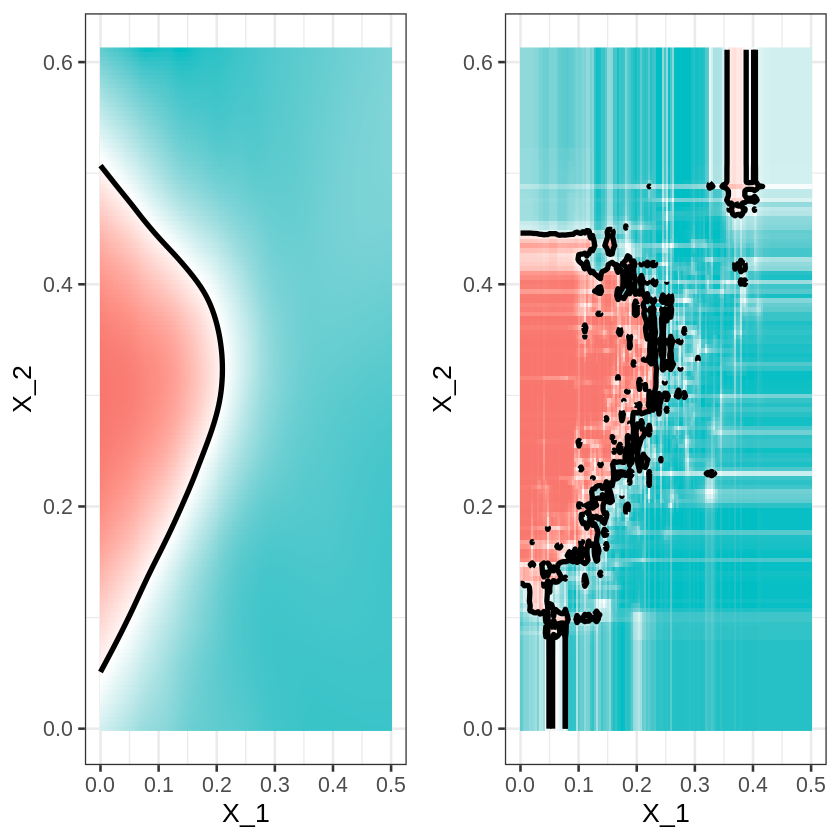

In [35]:
library(randomForest)
fit <- randomForest(label ~ X_1 + X_2, data = digits_train)
f_hat_rf <- predict(fit, newdata = true_f, type = "prob")[,2]

p <-true_f %>% mutate(f = f_hat_rf) %>%
               ggplot(aes(X_1, X_2, fill = f)) +
               scale_fill_gradientn(colors = c("#F8766D","white","#00BFC4")) + 
               geom_raster() + 
               stat_contour(aes(x = X_1, y = X_2, z = f), 
               data = mutate(true_f, f = f_hat_rf),
               breaks = c(0.5), color = "black", lwd = 1.5) +
               guides(fill = FALSE)

library(gridExtra)
grid.arrange(true_f_plot, p, nrow = 1)

We can control the "smoothness" of the random forest estimate in several ways. One way is to limit the size of each node. We can require the number of points per node to be larger:

Warning message:
“The following aesthetics were dropped during statistical transformation: fill
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


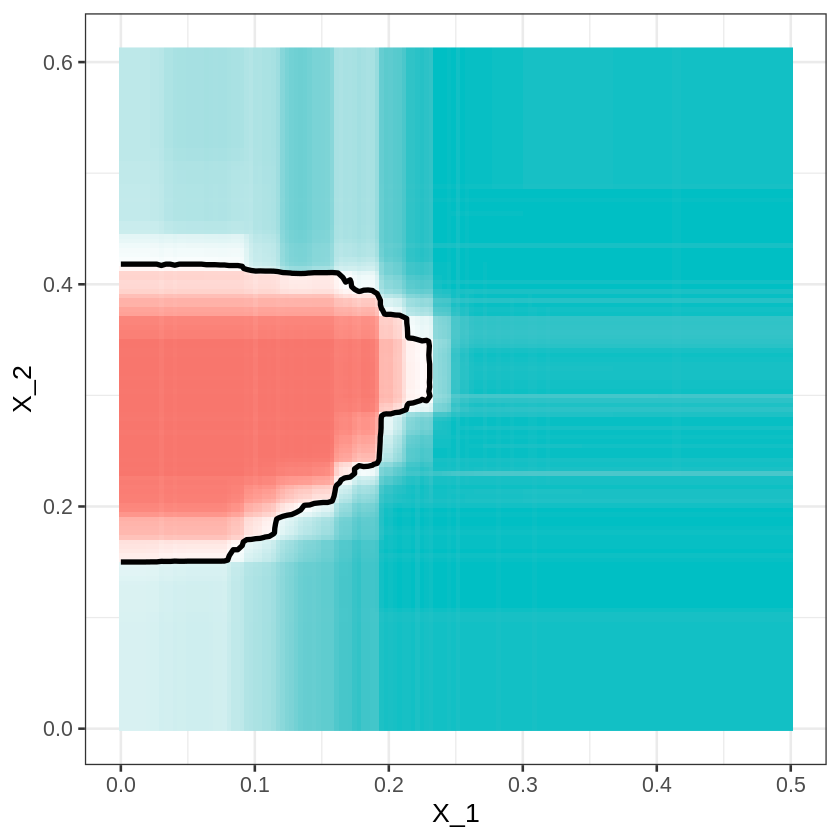

In [36]:
fit <- randomForest(as.factor(label) ~ X_1  +X_2,
                    nodesize = 250,
                    data = digits_train)
f_hat_rf <- predict(fit, newdata = true_f, type = "prob")[,2]

p <-true_f %>% mutate(f = f_hat_rf) %>%
               ggplot(aes(X_1, X_2, fill = f))  +
               scale_fill_gradientn(colors = c("#F8766D","white","#00BFC4")) + 
               geom_raster() +  
               stat_contour(aes(x = X_1, y = X_2, z = f), 
               data = mutate(true_f, f = f_hat_rf),
               breaks = c(0.5), color = "black", lwd = 1.5) +
               guides(fill = FALSE)

p

We can compare the results:

In [37]:
library(caret)

get_accuracy <- function(fit){
  pred <- predict(fit, newdata = digits_test, type = "class")
  confusionMatrix(table(pred = pred, true = digits_test$label))$overall[1]
}
fit <- tree(label ~ X_1 + X_2, data = digits_train)
get_accuracy(fit)

fit <- randomForest(label ~ X_1 + X_2, data = digits_train)
get_accuracy(fit)

fit <- randomForest(label ~ X_1 + X_2,
                    nodesize = 250,
                    data = digits_train)
get_accuracy(fit)

Accuracy 
0.808069

Accuracy 
0.8059701

Accuracy 
0.8206623

A disadvantage of random forests is that we lose interpretability. However, we can use the fact that a bootstrap sample was used to construct trees to measure _variable importance_ from the random forest.

Let's see this using all the digits data:

In [38]:
digits <- read_csv("hand-written-digits-train.csv")

digits <- mutate(digits, label = as.factor(label))

inTrain   <- l
train_set <- slice(digits, inTrain$Resample1)
test_set  <- slice(digits, -inTrain$Resample1)

fit <- randomForest(label~., ntree = 100, data = train_set)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



In [47]:
inTrain$Resample1

[1]     1     2     3     4     5     6     7     8     9    10    11    12
   [13]    13    15    16    17    18    20    21    22    23    25    26    27
   [25]    28    29    30    31    32    33    34    35    37    38    39    40
   [37]    41    42    43    44    45    46    47    48    49    51    52    53
   [49]    54    55    56    58    59    60    61    62    63    64    65    66
   [61]    67    68    69    70    71    72    73    74    75    76    77    79
   [73]    80    81    83    84    86    87    88    89    90    91    93    94
   [85]    95    96    97    98    99   100   101   102   103   104   105   106
   [97]   107   108   109   110   111   112   113   114   115   116   117   118
  [109]   119   120   121   123   124   125   126   127   128   130   131   132
  [121]   133   135   137   138   139   140   141   142   143   144   145   146
  [133]   147   148   150   151   152   153   154   156   157   158   160   161
  [145]   162   163   164   165   166   167   168   169   170   171   172   173
  [157]   174   177   178   179   180   181   182   183   185   186   187   188
  [169]   189   190   192   193   194   195   196   198   199   200   201   202
  [181]   203   204   205   206   207   208   209   210   211   212   213   214
  [193]   215   216   217   218   219   220   221   222   223   224   225   226
  [205]   227   228   229   230   231   232   234   236   237   238   239   240
  [217]   241   242   244   245   246   247   248   249   250   251   252   253
  [229]   255   256   257   258   259   260   261   262   263   264   265   266
  [241]   267   268   269   272   273   274   275   276   277   279   280   281
  [253]   282   283   284   285   286   287   288   289   291   292   293   294
  [265]   295   296   297   299   300   301   302   303   304   305   306   307
  [277]   308   309   310   311   312   315   316   317   318   319   320   321
  [289]   322   323   324   325   326   327   328   329   330   331   332   333
  [301]   334   335   336   337   338   339   340   343   344   345   346   347
  [313]   348   349   350   351   352   353   354   355   356   357   358   359
  [325]   360   361   362   363   364   365   366   367   368   369   370   371
  [337]   372   373   374   375   376   377   378   379   380   381   382   383
  [349]   384   385   386   387   388   389   390   391   393   394   395   396
  [361]   397   398   399   400   401   402   403   404   405   406   407   408
  [373]   410   411   412   413   414   415   417   418   420   421   422   423
  [385]   424   425   426   427   430   431   432   433   434   435   436   437
  [397]   438   439   440   442   443   444   445   446   447   448   449   450
  [409]   451   452   453   454   455   457   458   460   461   462   463   464
  [421]   465   466   467   468   470   471   473   474   475   476   477   478
  [433]   479   480   481   482   483   484   485   486   487   488   489   490
  [445]   491   492   493   494   495   496   497   498   499   500   501   502
  [457]   503   504   505   506   507   508   509   510   511   512   513   514
  [469]   515   516   517   518   519   520   521   523   524   525   526   527
  [481]   528   529   530   531   532   533   534   535   537   538   540   541
  [493]   542   544   545   547   549   550   551   552   553   555   556   557
  [505]   558   559   560   561   562   563   564   565   566   567   568   570
  [517]   571   572   573   574   575   576   577   578   580   581   582   583
  [529]   584   585   586   587   588   589   590   592   593   594   595   596
  [541]   597   598   599   600   601   603   604   606   607   608   609   610
  [553]   611   612   613   614   615   616   617   618   619   620   621   622
  [565]   624   625   626   627   630   631   632   633   634   635   636   637
  [577]   638   639   640   641   642   643   644   645   646   647   648   649
  [589]   650   651   652   653   654   656   657   658   659   660   661   663
  [6

How well does it do?

In [40]:
pred <- predict(fit, newdata = test_set, type = "class")
confusionMatrix(table(pred = pred, true = test_set$label))

Confusion Matrix and Statistics

    true
pred   0   1   2   3   4   5   6   7   8   9
   0 406   0   2   1   0   1   2   0   1   4
   1   0 461   0   0   2   1   1   1   2   0
   2   1   2 406   5   0   1   0   2   1   0
   3   0   2   1 408   0   9   0   0   4   6
   4   0   0   3   0 391   1   0   5   3   2
   5   0   0   0   6   0 356   4   0   3   2
   6   0   1   2   1   1   1 404   0   1   0
   7   0   1   0   2   0   0   0 425   0   6
   8   6   1   1   7   2   7   2   1 387   4
   9   0   0   2   5  11   2   0   6   4 394

Overall Statistics
                                          
               Accuracy : 0.9623          
                 95% CI : (0.9561, 0.9679)
    No Information Rate : 0.1115          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9581          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Cla

Here is a table of _variable importance_ for the random forest we just constructed.

In [41]:
library(knitr)
variable_importance <- importance(fit) 
tmp <- data_frame(feature = rownames(variable_importance),
                  Gini = variable_importance[,1]) %>%
                  arrange(desc(Gini))
kable(tmp[1:10,])

Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.”




|feature  |     Gini|
|:--------|--------:|
|pixel350 | 353.6952|
|pixel433 | 339.3635|
|pixel378 | 316.8655|
|pixel461 | 280.3615|
|pixel487 | 247.0005|
|pixel377 | 244.1287|
|pixel405 | 237.6620|
|pixel381 | 231.1008|
|pixel489 | 228.5381|
|pixel290 | 226.4892|

We can see where the "important" features are:


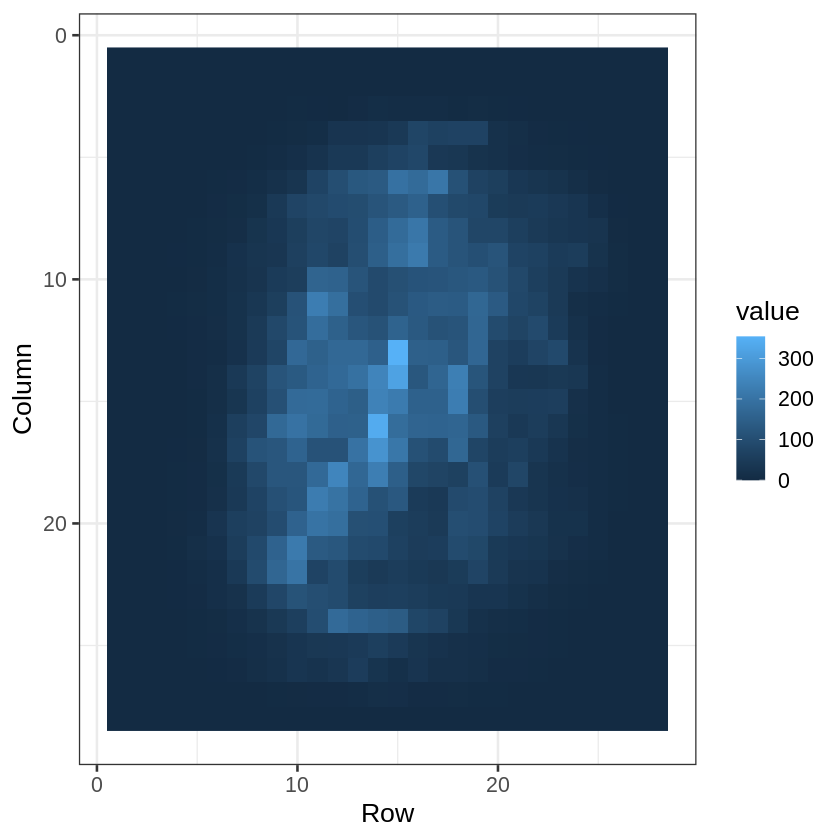

In [42]:
expand.grid(Row = 1:28, Column = 1:28) %>%
            mutate(value = variable_importance[,1]) %>%
            ggplot(aes(Row, Column, fill = value)) +
            geom_raster() +
            scale_y_reverse() 

And a barplot of the same data showing only the most predictive features:


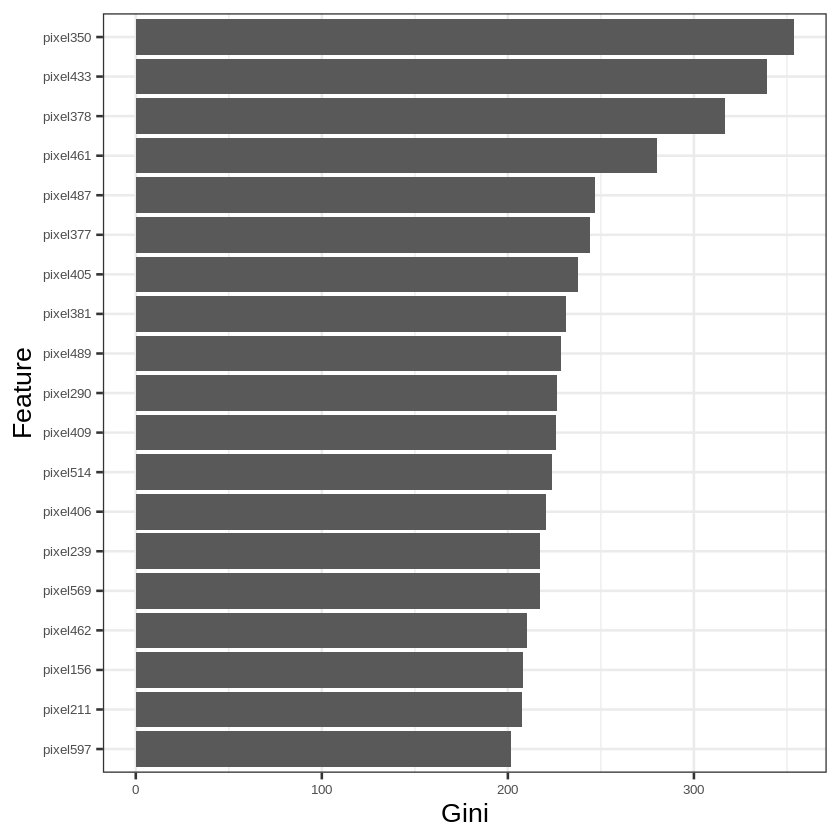

In [43]:
tmp %>% filter(Gini > 200) %>%
        ggplot(aes(x=reorder(feature, Gini), y=Gini)) +
        geom_bar(stat='identity') +
        coord_flip() + xlab("Feature") +
        theme(axis.text=element_text(size=8))

#### Tree-based methods summary

Tree-based methods are very interpretable _prediction_ models for which some inferential tasks are possible (e.g., variable importance in random forests), but are much more limited than the linear models we saw previously. These methods are very commonly used across many application domains and Random Forests often perform at state-of-the-art for many tasks.